In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)
from util import util_rul as util # Import our submodule
import os
import numpy as np
from sklearn.metrics import r2_score

# RUL Base Maintenance

Problem and Data

## Remaining Useful Life

**The _Remaining Useful Life_ is a key concept in predictive maintenance**

The RUL refers to _the time until a component becomes unusable_

* If we can estimate the RUL of a component
* ...We can schedule maintenance operations only when they are needed

**Current best practices are based on _preventive maintenance_**

I.e. on having a _fixed maintenance schedule_ for each component family

* RUL prediction can lead to significant savings
* ...By delaying maintenance operations w.r.t. the schedule
* ...But only as long as we are still able to prevent critical failures

## The Dataset

**We will consider the NASA [C-MAPSS dataset](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)**

* The Modular Aero-Propulsion System Simulation (MAPSS)
* ...Is a NASA-developed simulator for turbofan engines

<center><img src="assets/Turbofan3_Labelled.gif" width="30%"/></center>

* It comes with both a Military (MAPSS) and commercial versionn (C-MAPSS)
* They different in the attributes of the considered engines

## The Dataset

**The C-MAPSS system can simulate a number of faults and defects**

...And it was used to build a high-quality dataset for a competition

* The dataset consists of 4 "training set" files and 4 "test set" files
* The dataset differ by operating conditions (sea level only or different altitudes)
* ...And by fault types (High Pressure Compressor, fan)
* All engines are assumed to be healthy at the beginning of the simulation

**We will focus on the hardest setup**

* Multiple operating conditions
* Two fault types

## Inspecting the Data

**Let's have a look at the row data**

In [2]:
data_raw = util.load_data(data_folder=os.path.join('..', 'data'))
data_dict = util.split_by_field(data_raw, field='src')
data = data_dict['train_FD004']
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,train_FD004,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,train_FD004,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,train_FD004,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,train_FD004,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


* Columns "p1, p2, p3" refer to controlled parameters
* Columns "s1" to "s21" refer to sensor reading
* Binning has already been applied in the original dataset

## Statistics

**Let's check some statistics**

In [3]:
dt_in = list(data.columns[3:-1]) # Exclude metadata
data[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,23.999823,0.571347,94.031576,472.882435,579.420056,1417.896600,1201.915359,8.031626,11.589457,283.328633,...,266.735665,2334.427590,8067.811812,9.285604,0.023252,347.760029,2228.613283,97.751396,20.864333,12.518995
std,14.780722,0.310703,14.251954,26.436832,37.342647,106.167598,119.327591,3.622872,5.444017,146.880210,...,138.479109,128.197859,85.670543,0.750374,0.004685,27.808283,145.472491,5.369424,9.936396,5.962697
min,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,5.670000,136.170000,...,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,10.004600,0.250700,100.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,5.720000,142.920000,...,134.520000,2387.910000,8062.630000,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100
50%,25.001400,0.700000,100.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,9.030000,194.960000,...,183.450000,2388.060000,8083.810000,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100
75%,41.998100,0.840000,100.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,15.480000,394.280000,...,371.400000,2388.170000,8128.350000,9.365800,0.030000,368.000000,2324.000000,100.000000,28.560000,17.135500
max,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,21.610000,570.810000,...,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200


There are appears to be no missing value

## Heatmaps


**We'll use a heatmap to get a glance of all data at once**

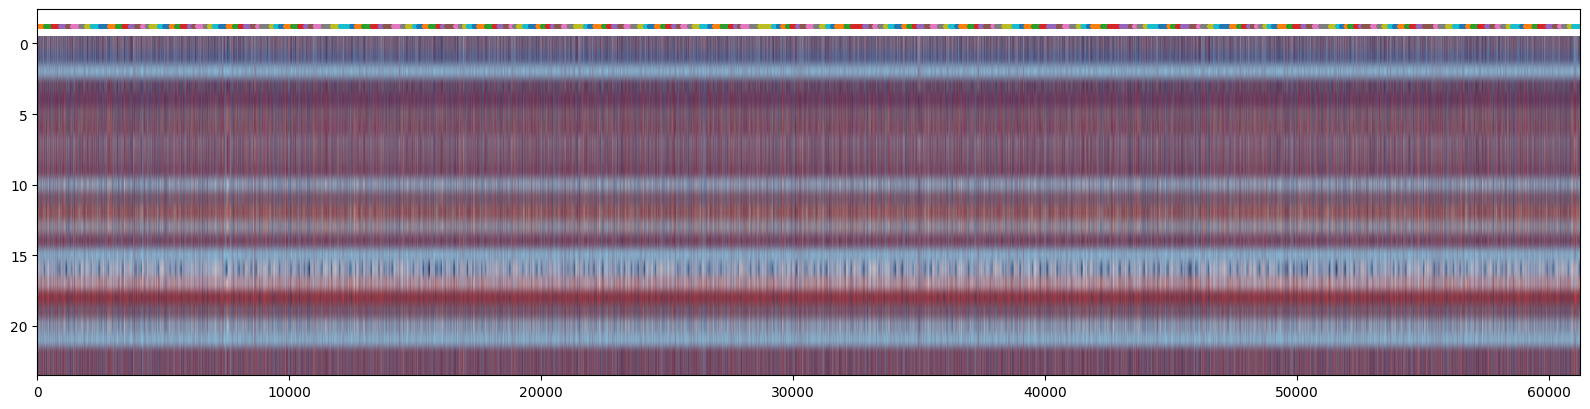

In [4]:
util.plot_dataframe(data[dt_in], labels=data['machine'], figsize=figsize, vmin=-1, vmax=1)

* Time is on the x-axis, every row corresponds to a table column
* Red = below average, blue = above average

## A Sample Column

**Let's plot one column in deeper detail _for a single machine/experiment_**

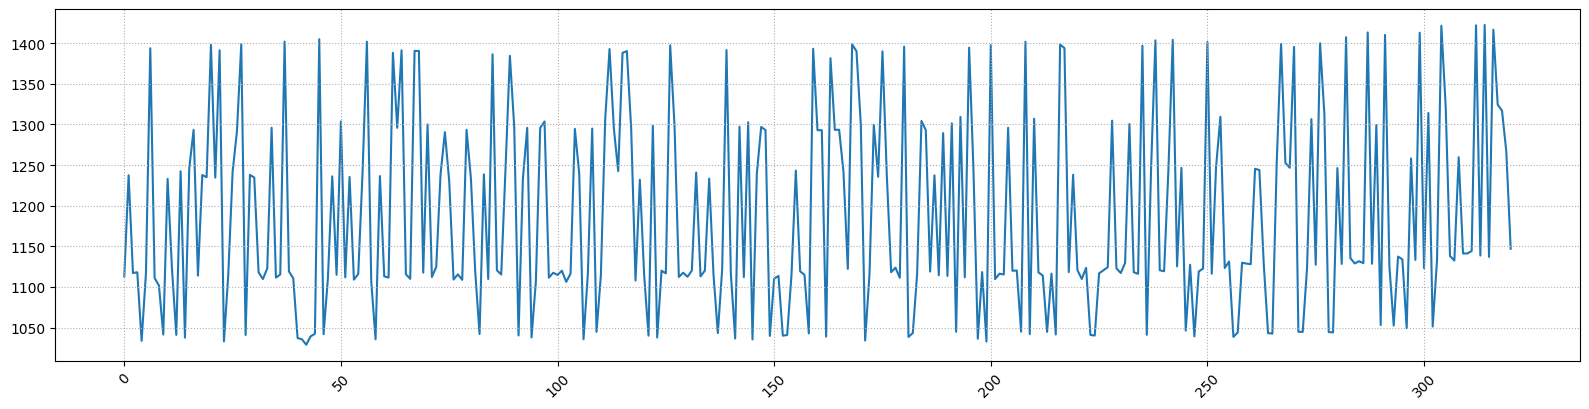

In [5]:
tmp = data[data['machine'] == data['machine'].iloc[0]]
util.plot_series(tmp['s4'], figsize=figsize)

* There might be an increasing trend, but it's quit weak

## Remaining Useful life

**Let's have a look at the "rul" column**

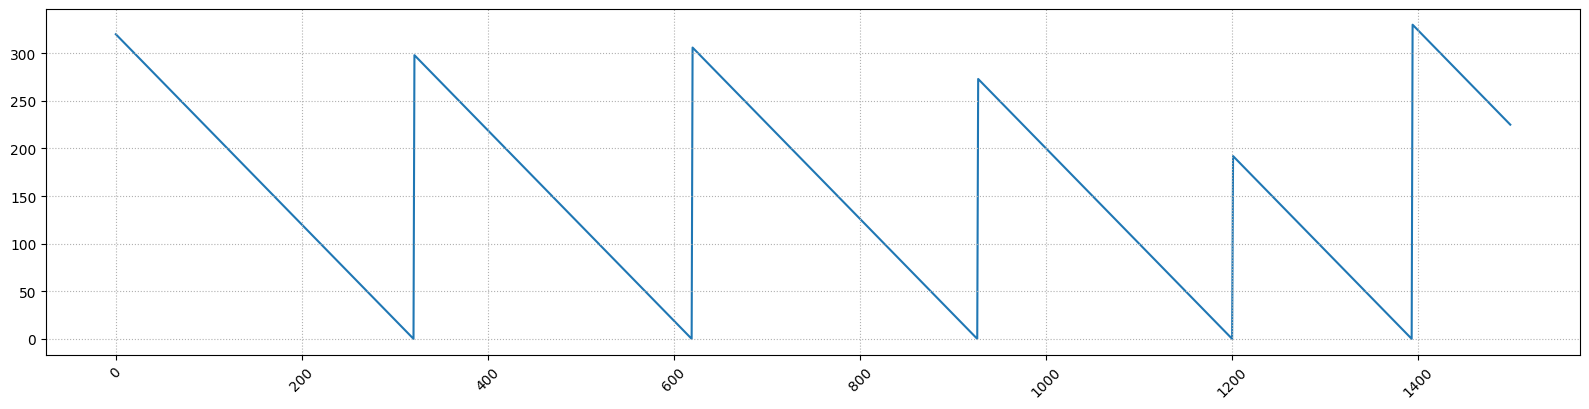

In [6]:
util.plot_series(data['rul'].iloc[:1500], figsize=figsize)

* It has a saw-tooth pattern, since the duration of each experiment is known

# RUL Base Maintenance

### RUL Prediction

<div class=big><small>Say we want to define a RUL-based maintenance policy</small><br>How could we tackle that problem?</div>

## System Modeling

**Let's start from modeling the system**

We can view the RUL and the observed data as 

$$
X, R \sim P(X, R)
$$

Since $X$ is observed, we can actually focus on the conditional distribution of $R$:

$$
R \sim P(R \mid X)
$$

We can then define the expected RUL given observed values $x$ for $X$:

$$
f(x) = \mathrm{E}_{R \sim P(R \mid X=x)} \left[ R \right]
$$

This is exactly just the formalization for a classical _regression problem_

## RUL Prediction as Regression

**With this information, we can formulate a simple maintenance policy**

We will _train a regression model_ $\hat{y} = \hat{f}(x; \theta)$ to approximate $f(x)$

* We can use any regression approach in principle
* E.g. linear regression, Neural Networks, Random Forests, etc.

Then we trigger maintenance when the estimated RUL becomes too low, i.e.:

$$
\hat{y} = \hat{f}(x; \theta) \leq \varepsilon
$$

* $\theta$ is the vector of model parameters
* The threshold $\varepsilon$ must account for possible estimation errors

<div class=big><span style='font-size:0.8em'>We now need to define our training and test data</span><br/>How do we proceed?</div>

## Training and Test Data

**We now need to define our training and test data**

In a practical setting:

* Some run-to-failure experiments will form the training set
* Others run-to-failure experiments will be used for testing

I.e. we split _whole experiments_ rather than individual examples! 

**Each run-to-failure experiment in our data is associated to a machine**

Let's check how many we have:

In [7]:
print(f'Number of machines: {len(data.machine.unique())}')

Number of machines: 249


* This is actually a _very large_ number (way more than typically available)

## Training and Test Data

**Let's use 75% of the machine for training, the rest for testing**

First, we partition the machine indexes:

In [8]:
tr_ratio = 0.75
np.random.seed(42)
machines = data.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

Then, we partition the dataset itself:

In [9]:
tr, ts = util.partition_by_machine(data, tr_mcn)

## Training and Test Data

**Let's have a look at the training data**

In [10]:
tr

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,train_FD004,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,train_FD004,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,train_FD004,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,train_FD004,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60989,train_FD004,248,180,35.0019,0.8409,100.0,449.44,556.28,1377.65,1148.96,...,2387.77,8048.91,9.4169,0.02,337,2223,100.00,14.66,8.7446,4
60990,train_FD004,248,181,0.0023,0.0000,100.0,518.67,643.95,1602.98,1429.57,...,2388.27,8122.44,8.5242,0.03,396,2388,100.00,38.40,23.1079,3
60991,train_FD004,248,182,25.0030,0.6200,60.0,462.54,536.88,1268.01,1067.09,...,2027.98,7865.18,10.9790,0.02,309,1915,84.93,14.24,8.4254,2
60992,train_FD004,248,183,41.9984,0.8414,100.0,445.00,550.64,1363.76,1145.72,...,2387.48,8069.84,9.4607,0.02,333,2212,100.00,10.37,6.2727,1


## Training and Test Data

**...And at the test data**

In [11]:
ts

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
321,train_FD004,2,1,41.9998,0.8400,100.0,445.00,548.99,1341.82,1113.16,...,2387.98,8082.37,9.3300,0.02,331,2212,100.00,10.77,6.2894,298
322,train_FD004,2,2,9.9999,0.2500,100.0,489.05,604.23,1498.00,1299.54,...,2388.07,8125.46,8.6088,0.03,368,2319,100.00,28.61,17.3135,297
323,train_FD004,2,3,42.0079,0.8403,100.0,445.00,549.11,1351.47,1126.43,...,2387.93,8082.11,9.2965,0.02,330,2212,100.00,10.70,6.4288,296
324,train_FD004,2,4,42.0077,0.8400,100.0,445.00,548.77,1345.81,1116.64,...,2387.88,8079.41,9.3200,0.02,330,2212,100.00,10.50,6.2818,295
325,train_FD004,2,5,24.9999,0.6200,60.0,462.54,537.00,1259.55,1043.95,...,2028.13,7867.08,10.8841,0.02,307,1915,84.93,14.26,8.5789,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,train_FD004,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,...,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,4
61245,train_FD004,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,...,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,3
61246,train_FD004,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,...,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,2
61247,train_FD004,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,...,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,1


## Standardization/Normalization

**We will use a Neural Network regressor**

...Therefore, we need to make the range of each columns more uniform

* We will _standardize_ all parameters and sensor inputs:

In [12]:
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

* We will _normalize_ the RUL values (i.e. our regression target)

In [13]:
trmaxrul = tr['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

## Standardization/Normalization

**Let's check the results**

In [14]:
tr_s.describe()

,machine,cycle,p1,p2,p3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
count,45385.000000,45385.000000,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,...,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,4.538500e+04,45385.000000
mean,122.490955,133.323896,2.894775e-16,1.302570e-16,1.178889e-16,4.664830e-15,2.522791e-15,1.727041e-15,-6.633794e-16,1.496703e-16,...,1.135835e-15,-6.017186e-15,-1.409030e-16,-1.058182e-15,-6.532030e-16,1.583594e-16,-3.093135e-15,2.572263e-16,-1.477916e-16,0.244140
std,71.283034,89.568561,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.165256
min,1.000000,1.000000,-1.623164e+00,-1.838222e+00,-2.381839e+00,-1.055641e+00,-1.176507e+00,-1.646830e+00,-1.486984e+00,-1.138606e+00,...,-2.387561e+00,-2.583315e+00,-1.480340e+00,-6.950269e-01,-1.644539e+00,-2.151433e+00,-2.381839e+00,-1.077489e+00,-1.079308e+00,0.000000
25%,61.000000,62.000000,-9.461510e-01,-1.031405e+00,4.198344e-01,-1.055641e+00,-8.055879e-01,-6.341243e-01,-6.912917e-01,-1.138606e+00,...,4.181950e-01,-5.977256e-02,-8.501637e-01,-6.950269e-01,-6.379310e-01,-1.126840e-01,4.198344e-01,-9.979498e-01,-9.988926e-01,0.112546
50%,125.000000,123.000000,6.868497e-02,4.154560e-01,4.198344e-01,-3.917563e-01,-6.336530e-01,-4.718540e-01,-5.429267e-01,-2.714913e-01,...,4.194408e-01,1.862163e-01,-4.025983e-02,-6.950269e-01,-4.941298e-01,-3.717480e-02,4.198344e-01,-5.972306e-01,-5.971843e-01,0.225092
75%,179.000000,189.000000,1.218855e+00,8.661917e-01,4.198344e-01,6.926385e-01,7.407549e-01,7.495521e-01,8.439630e-01,6.867534e-01,...,4.202973e-01,7.086220e-01,1.055441e-01,1.438762e+00,7.641306e-01,6.561373e-01,4.198344e-01,7.740747e-01,7.744926e-01,0.346863
max,248.000000,543.000000,1.219524e+00,8.726308e-01,4.198344e-01,1.732749e+00,1.741030e+00,1.837978e+00,2.000975e+00,1.818973e+00,...,4.383623e-01,2.264997e+00,2.365107e+00,1.438762e+00,1.806689e+00,1.095464e+00,4.198344e-01,1.915822e+00,1.907272e+00,1.000000


## Regression Model

**We will start with _the simplest possible_ Neural Network**

...Meaning a _Linear Regressor_!

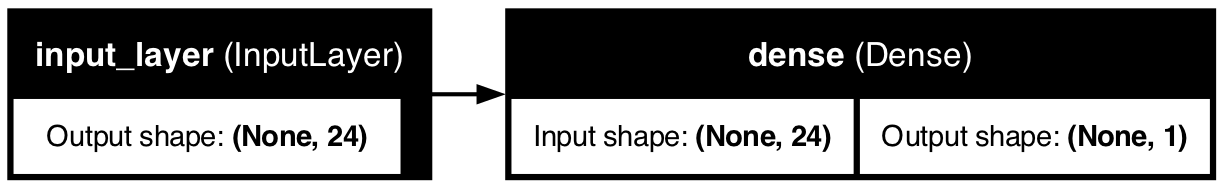

In [15]:
nn1 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[])
util.plot_nn_model(nn1, dpi=150)

* We just need to specify that there are no hidden layers
* Why the simplest? As usual, due to [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor)

## Training

**We can now train our model**

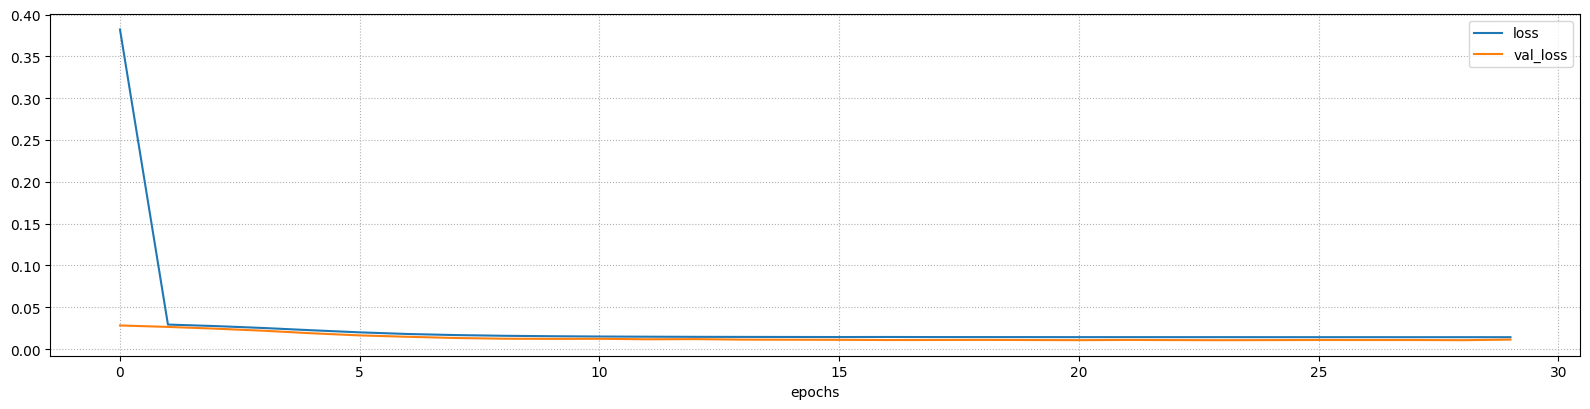

Final loss: 0.0142 (training), 0.0114 (validation)


In [16]:
nn1 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[])
history = util.train_nn_model(nn1, tr_s[dt_in], tr_s['rul'], loss='mse', epochs=30, validation_split=0.2, batch_size=32)
util.plot_training_history(history, figsize=figsize)

## Training

**Let's try with a more complex model**

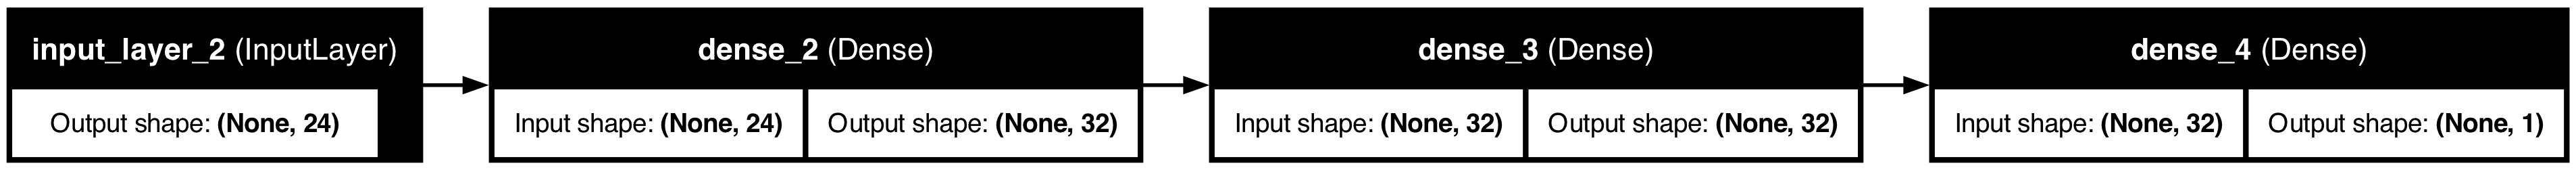

In [17]:
nn2 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32, 32])
util.plot_nn_model(nn2, dpi=200)

* Now we have two hidden layers
* ...Each with 32 ReLU neurons

## Training

**Let's check the loss behavior and compare it to Linear Regression**

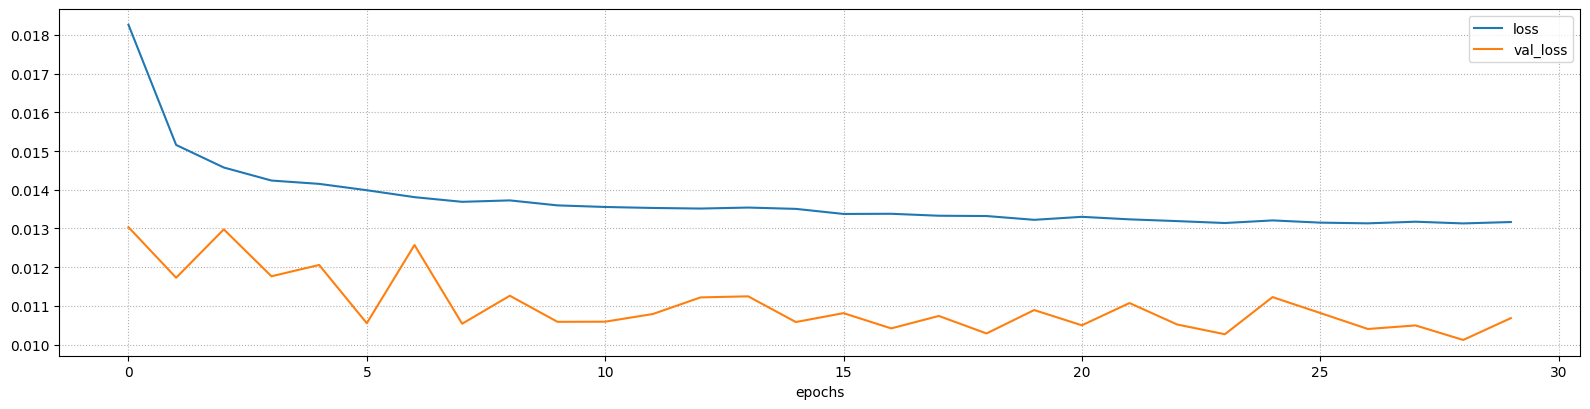

Final loss: 0.0132 (training), 0.0107 (validation)


In [18]:
nn2 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32, 32])
history = util.train_nn_model(nn2, tr_s[dt_in], tr_s['rul'], loss='mse', epochs=30, validation_split=0.2, batch_size=32)
util.plot_training_history(history, figsize=figsize)

* There is a small improvement w.r.t. Linear Regression

## Predictions

**We can now obtain the predictions and evaluate their quality**

R2 score: 0.5432


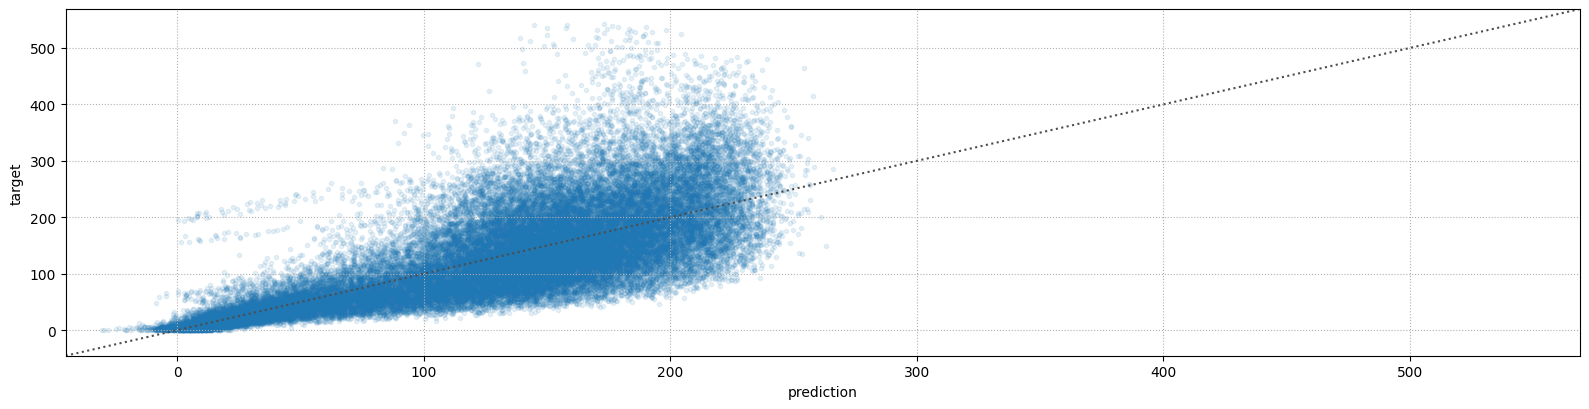

In [19]:
tr_pred = nn2.predict(tr_s[dt_in], verbose=0).ravel() * trmaxrul
util.plot_pred_scatter(tr_pred, tr['rul'], figsize=figsize)
print(f'R2 score: {r2_score(tr["rul"], tr_pred):.4f}')

<div class=big>
What do you think of these results?<br>
Are they good or bad?
</div>

## Predictions

**The results so far are not comforting**

...But it's worth seeing what is going on over time:

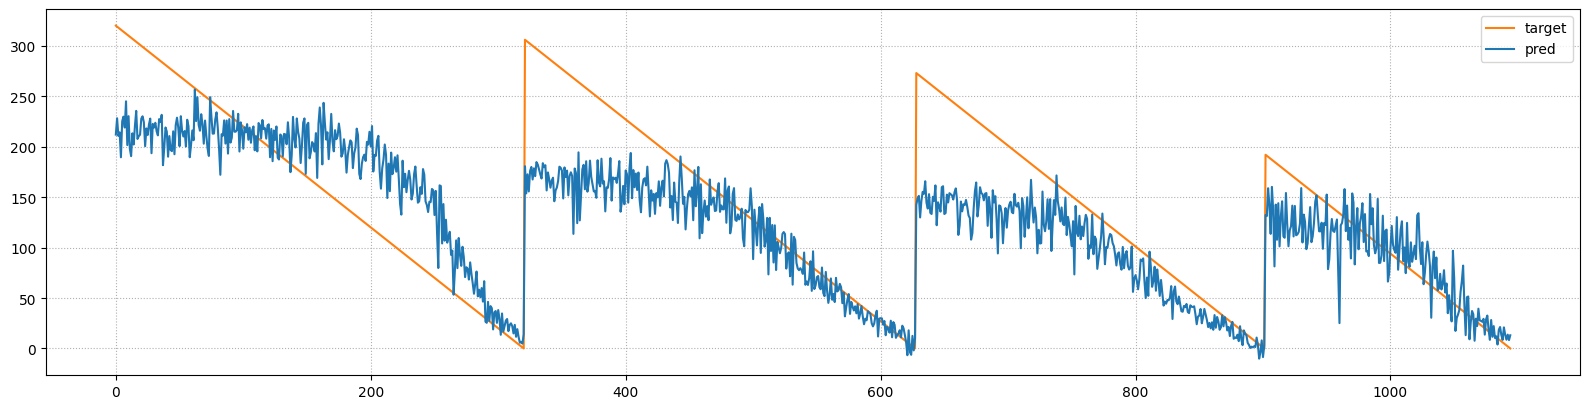

In [20]:
stop = 1095
util.plot_rul(tr_pred[:stop], tr['rul'][:stop], figsize=figsize)

## Predictions

**The situation is similar on the test set:**

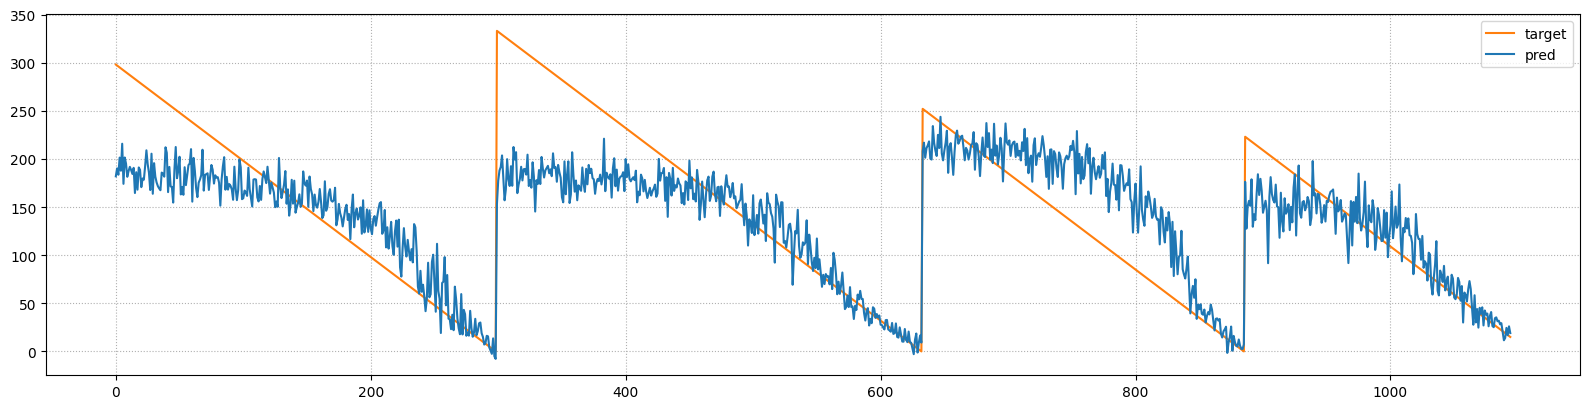

In [21]:
ts_pred = nn2.predict(ts_s[dt_in], verbose=0).ravel() * trmaxrul
util.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=figsize)

## Quality Evaluation

**Let's try to recap the situation**

Our accuracy is quite poor especially for large RUL values

* This may happens since large RUL value are somewhat scarce on the dataset
* ...Or because fault effects become noticeable only after a while

**But perhaps we don't care! Our goal is _not a high accuracy_**

* We just need to _stop at the right time_
* ...And our model may still be good enough for that

> **For a proper evaluation, we need a _cost model_**

## Cost Model

**We will assume that:**

We consider _one step_ of operation as our _value unit_

* ...So we can express the failure cost in terms of operating steps

Every run end with either _failure or maintenance_:

* Assuming that the failure cost is higher than maintenance cost
* ...We can diseregard the maintenance cost 

A traditional _preventive maintenance_ policy is also available

* We will never trigger maintenance ealier that such policy
* We only gain value if we beat such policy

## Cost Model

**The whole cost formula _for a single machine_ will be:**

$$
\mathit{cost}(\hat{y}), \varepsilon) = \mathit{op\_profit}(\hat{y}, \varepsilon) + \mathit{fail\_cost}(\hat{y}, \varepsilon)
$$

Where:

$$
\mathit{op\_profit}(\hat{y}, \varepsilon) = -\max(0, \mathit{stop\_time}(\hat{y}, \varepsilon) -s) \\
\mathit{fail\_cost}(\hat{y}, \varepsilon) = \left\{
\begin{align}
& C \text{ if } \max(\hat{y}) \geq \varepsilon \\
& 0 \text{ otherwise}
\end{align}
\right.
$$

* If we fail, we pay $C$ cost unit more than maintenance
* Profit is modeled as a negative cost
* We only make profit if we stop after $s$ units

## Cost Model

**Normally, we would proceed as follows**

* $s$ is determined by the preventive maintenance schedule
* $C$ must be determined by discussing with the customer

In our example, we will derive both from data

**First, we collect all failure times**

In [22]:
failtimes = data.groupby('machine')['cycle'].max()
failtimes.head()

machine
1    321
2    299
3    307
4    274
5    193
Name: cycle, dtype: int64

## Cost Model

**Then, we define $s$ and $C$ based on statistics**

In [23]:
print(failtimes.describe())
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

count    249.00000
mean     245.97992
std       73.11080
min      128.00000
25%      190.00000
50%      234.00000
75%      290.00000
max      543.00000
Name: cycle, dtype: float64


* For the safe interval $s$, we choose the minimum failure time
* For the maintenance cost $C$ we choose the largest failure time

## Threshold Choice

**We can then choose the threshold $\theta$ as usual**

Optimal threshold for the training set: 7


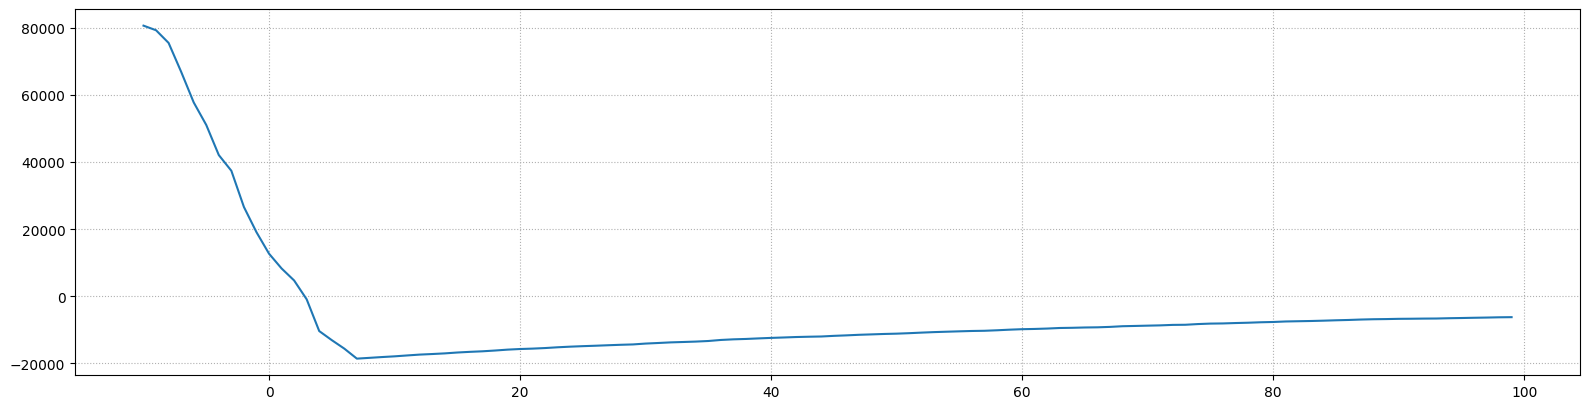

In [24]:
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 100)
tr_thr = util.opt_threshold_and_plot(tr['machine'].values, tr_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr}')

## Evaluation

**Let's see how we fare in terms of cost**

In [25]:
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, tr_thr, return_margin=True)
print(f'Avg. cost: {tr_c/len(tr_mcn):.2f} (training), {ts_c/len(ts_mcn):.2f} (test)')

Avg. cost: -100.15 (training), -110.10 (test)


We can also evaluate the margin for improvement:

In [26]:
print(f'Avg. fails: {tr_f/len(tr_mcn):.2f} (training), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (training), 0.00 (test)
Avg. slack: 16.11 (training), 13.71 (test)


* Slack = distance between when we stop and the failure
* The results are quite good and we also generalize fairly well